In [28]:
## Import libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [29]:
## LOAD DATA AND EXPLORATORY ANALYSIS

In [30]:
## Load dataset and drop unusefull columns
X_full = pd.read_csv('methods_dataset.csv')
X_full.shape

(295815, 15)

In [31]:
X_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295815 entries, 0 to 295814
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   Unnamed: 0           295815 non-null  int64
 1   fanin                295815 non-null  int64
 2   fanout               295815 non-null  int64
 3   wmc                  295815 non-null  int64
 4   loc                  295815 non-null  int64
 5   returnsQty           295815 non-null  int64
 6   variablesQty         295815 non-null  int64
 7   parametersQty        295815 non-null  int64
 8   loopQty              295815 non-null  int64
 9   maxNestedBlocksQty   295815 non-null  int64
 10  anonymousClassesQty  295815 non-null  int64
 11  innerClassesQty      295815 non-null  int64
 12  uniqueWordsQty       295815 non-null  int64
 13  featureEnvy          295815 non-null  int64
 14  longMethod           295815 non-null  int64
dtypes: int64(15)
memory usage: 33.9 MB


In [32]:
## Initial data treatment
X_full.drop(['longMethod'], axis=1, inplace=True)
X_full.drop(['Unnamed: 0'],axis=1,inplace=True)
X_full.dropna(inplace=True)
X_full.shape

(295815, 13)

In [33]:
## Show dataframe header
X_full.head(1)

,fanin,fanout,wmc,loc,returnsQty,variablesQty,parametersQty,loopQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,uniqueWordsQty,featureEnvy
0,0,1,1,3,0,0,1,0,0,0,0,10,0


In [34]:
## Is any empty feature?
np.any(np.isnan(X_full))

False

In [35]:
## SPLIT DATA

In [36]:
## Split dataset in metrics and godsmell ds
X = X_full.drop(['featureEnvy'], axis=1)
y = X_full.featureEnvy

In [37]:
SEED = 0

In [38]:
## Split train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=SEED)

In [39]:
import collections
collections.Counter(y_test)

Counter({0: 58201, 1: 962})

In [40]:
## PIPELINE

In [41]:
## Import descision tree lib
from sklearn.tree import DecisionTreeClassifier

In [42]:
#decision_tree_regressor = DecisionTreeRegressor(random_state=SEED, criterion='mse')
dtreeCLF = DecisionTreeClassifier(random_state=SEED)

In [43]:
pipe = Pipeline(steps=[
            ('minmaxscaler', MinMaxScaler()),
            ('dtreeCLF', dtreeCLF)
    ])

In [44]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'minmaxscaler', 'dtreeCLF', 'minmaxscaler__copy', 'minmaxscaler__feature_range', 'dtreeCLF__ccp_alpha', 'dtreeCLF__class_weight', 'dtreeCLF__criterion', 'dtreeCLF__max_depth', 'dtreeCLF__max_features', 'dtreeCLF__max_leaf_nodes', 'dtreeCLF__min_impurity_decrease', 'dtreeCLF__min_impurity_split', 'dtreeCLF__min_samples_leaf', 'dtreeCLF__min_samples_split', 'dtreeCLF__min_weight_fraction_leaf', 'dtreeCLF__presort', 'dtreeCLF__random_state', 'dtreeCLF__splitter'])

In [45]:
parameters = dict(
    dtreeCLF__max_depth = list(range(1, 33)),
    dtreeCLF__min_samples_split = [32,64,128,256],
    dtreeCLF__min_samples_leaf = [32,64,128,256],
    dtreeCLF__criterion = ["gini", "entropy"]
)

In [46]:
## TUNING THE MODEL

In [47]:
## Import libs
from sklearn.model_selection import RandomizedSearchCV, KFold

In [48]:
## Randomized Search Instance
randomized_search = RandomizedSearchCV(pipe,parameters,cv = KFold(n_splits=10),n_iter=100,random_state=SEED,scoring='neg_mean_squared_error')

In [49]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                             ('dtreeCLF',
                                              DecisionTreeClassifier(random_state=0))]),
                   n_iter=100,
                   param_distributions={'dtreeCLF__criterion': ['gini',
                                                                'entropy'],
                                        'dtreeCLF__max_depth': [1, 2, 3, 4, 5,
                                                                6, 7, 8, 9, 10,
                                                                11, 12, 13, 14,
                                                                15, 16, 17, 18,
                                                                19, 20, 21, 22,
                                                                23, 24, 25, 26,
                                        

In [50]:
resultados = pd.DataFrame(randomized_search.cv_results_)
resultados.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dtreeCLF__min_samples_split,param_dtreeCLF__min_samples_leaf,param_dtreeCLF__max_depth,param_dtreeCLF__criterion,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.581507,0.014197,0.012500,0.006250,256,256,26,entropy,"{'dtreeCLF__min_samples_split': 256, 'dtreeCLF...",-0.016226,...,-0.016142,-0.01517,-0.015339,-0.015212,-0.016438,-0.015001,-0.016184,-0.015593,0.000628,3
1,0.183231,0.003268,0.005238,0.007874,256,128,2,gini,"{'dtreeCLF__min_samples_split': 256, 'dtreeCLF...",-0.016226,...,-0.016142,-0.01517,-0.015339,-0.015212,-0.016438,-0.015001,-0.016184,-0.015593,0.000628,3


In [51]:
## Print best params
randomized_search.best_params_

{'dtreeCLF__min_samples_split': 128,
 'dtreeCLF__min_samples_leaf': 32,
 'dtreeCLF__max_depth': 11,
 'dtreeCLF__criterion': 'entropy'}

In [52]:
## Print best score
randomized_search.best_score_

-0.015584060726510706

In [53]:
## TRAINING THE BEST MODEL

In [54]:
## Traning best model
tuned_hyper_model= DecisionTreeClassifier(random_state=SEED, criterion='entropy', min_samples_split=128, min_samples_leaf=32, max_depth=11)
tuned_hyper_model.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=11, min_samples_leaf=32,
                       min_samples_split=128, random_state=0)

In [55]:
tuned_hyper_model.feature_importances_

array([0.02234474, 0.59042025, 0.02407603, 0.10718967, 0.01472192,
       0.02836127, 0.0728714 , 0.00293026, 0.0278998 , 0.02448802,
       0.        , 0.08469664])

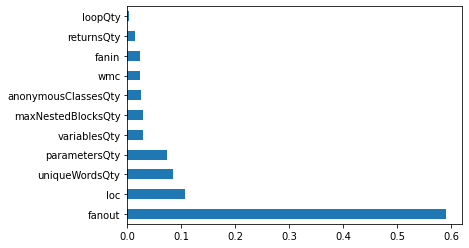

In [56]:
feat_importances = pd.Series(tuned_hyper_model.feature_importances_, index=X_test.columns)
feat_importances.nlargest(11).plot(kind='barh')
plt.show()

In [57]:
## Prediction
y_pred=tuned_hyper_model.predict(X_test)

In [58]:
collections.Counter(y_pred)

Counter({0: 59152, 1: 11})

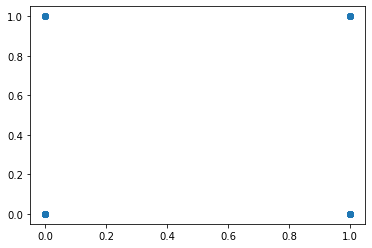

In [59]:
## Plot result
plt.scatter(y_test,y_pred)

In [60]:
## EVALUATE

In [61]:
## Evaluate error rate
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.01624326014569917
MSE: 0.01624326014569917
RMSE: 0.12744904921457503


In [62]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [63]:
accuracy_score(y_test, y_pred.round())

0.9837567398543008

In [64]:
precision_score(y_test, y_pred.round())

0.5454545454545454

In [65]:
recall_score(y_test, y_pred.round())

0.006237006237006237

In [66]:
f1_score(y_test, y_pred.round())

0.012332990750256937